## Домашнее задание «Сегментация и детекция объектов»

**Задание:**
**Распознавание рукописного ввода на примере базы MNIST**

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук [002-digit.ipynb](https://github.com/a4tunado/lectures/blob/master/002/002-digit.ipynb).

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста [Digit Recognizer](https://www.kaggle.com/c/digit-recognizer) на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

**Решение:**

In [ ]:
# Импортируем бибилиотеки
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage.feature import hog
import seaborn as sns

In [ ]:
# Подключаем Google Disk
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Загрузка данных
train_url = ('/content/drive/MyDrive/Middle Data Science/Computer Vision/train.csv')
test_url = ('/content/drive/MyDrive/Middle Data Science/Computer Vision/test.csv')

In [ ]:
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

X = train_df.iloc[:, 1:].values.reshape(-1, 28, 28)
y = train_df.iloc[:, 0].values

In [ ]:
# Проверка первых нескольких строк обучающего набора
print("Обучающий набор:")
print(train_df.head())

# Проверка размерности обучающих данных
print(f"Размер обучающего набора: {X.shape}, Размер меток: {y.shape}")

# Проверка первых нескольких строк тестового набора
print("\nТестовый набор:")
print(test_df.head())

# Проверка размерности тестовых данных
# Предполагается, что тестовый набор содержит только пиксели без меток
test_X = test_df.values.reshape(-1, 28, 28)
print(f"Размер тестового набора: {test_X.shape}")

Обучающий набор:
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0  

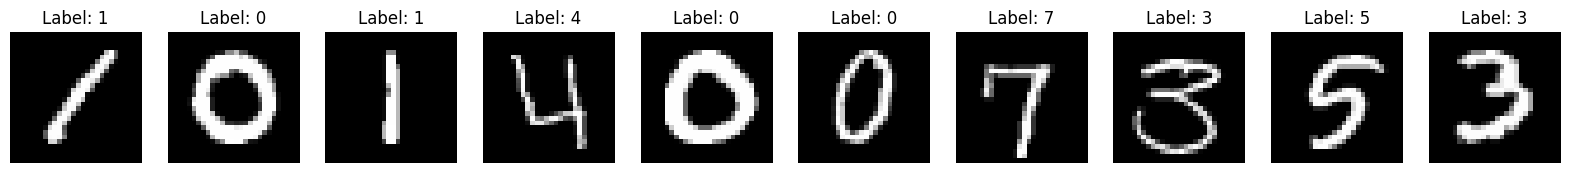

In [ ]:
# Визуализируем 10 случайных образцов из обучающего набора
def plot_samples(X, y, num_samples=10):
    plt.figure(figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[i], cmap='gray')
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.show()

plot_samples(X, y, num_samples=10)

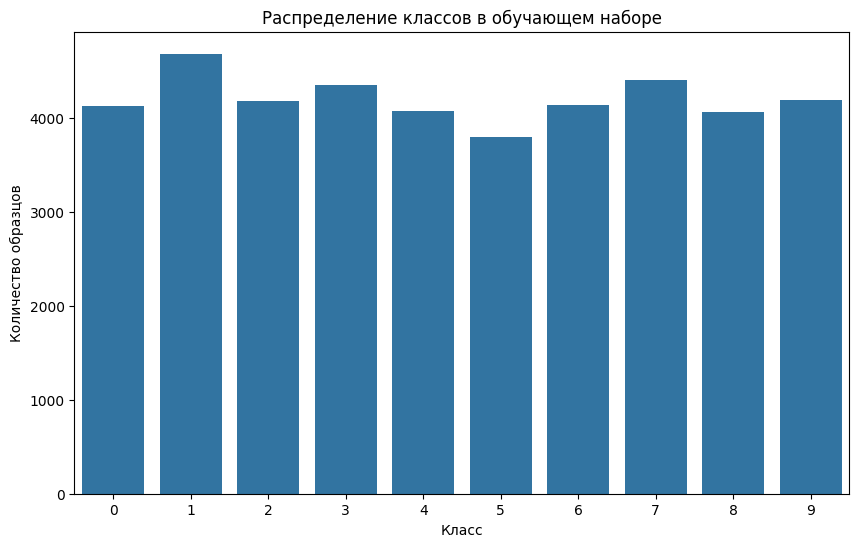

In [ ]:
# Посмотрим, есть ли специфика в распределении классов

plt.figure(figsize=(10,6))
sns.countplot(x=y)
plt.title("Распределение классов в обучающем наборе")
plt.xlabel("Класс")
plt.ylabel("Количество образцов")
plt.show()

In [ ]:
# Преобразование типов данных в float32 и нормализация
X = X.astype('float32') / 255.0
test_X = test_X.astype('float32') / 255.0

print(f"Тип данных X после нормализации: {X.dtype}, min: {X.min()}, max: {X.max()}")

Тип данных X после нормализации: float32, min: 0.0, max: 1.0


In [ ]:
from sklearn.model_selection import train_test_split

# Разделение данных: 80% обучение, 20% валидация
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")

Размер обучающей выборки: (33600, 28, 28)
Размер валидационной выборки: (8400, 28, 28)


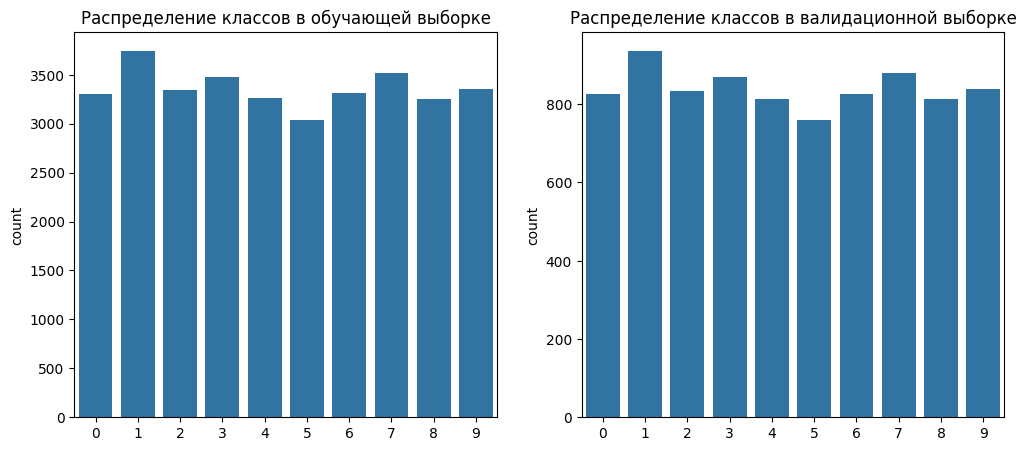

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title("Распределение классов в обучающей выборке")

sns.countplot(x=y_val, ax=axes[1])
axes[1].set_title("Распределение классов в валидационной выборке")

plt.show()

In [ ]:
# Используем гистограмму направленных градиентов
def extract_hog_features(images):
    features = []

    for i in range(images.shape[0]):
        image = images[i]
        # Извлекаем HOG признаки
        hog_feature = hog(image, pixels_per_cell=(4, 4), cells_per_block=(2, 2),
                          block_norm='L2-Hys', visualize=False)
        features.append(hog_feature)

    return np.array(features)

# Извлекаем HOG-признаки для обучающей выборки
X_hog = extract_hog_features(X)
print("HOG features shape:", X_hog.shape)

HOG features shape: (42000, 1296)


In [ ]:
# Разделяем данные на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X_hog, y, test_size=0.2, random_state=42)

# Стандартизируем данные
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Обучаем модель SVM
model = SVC(kernel='linear', random_state=42)
model.fit(X_train, y_train)

# Прогнозируем на валидационной выборке
y_pred = model.predict(X_val)

# Оцениваем точность модели
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9744


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       816
           1       0.98      0.99      0.99       909
           2       0.98      0.97      0.97       846
           3       0.97      0.97      0.97       937
           4       0.97      0.97      0.97       839
           5       0.98      0.96      0.97       702
           6       0.98      0.98      0.98       785
           7       0.98      0.97      0.98       893
           8       0.96      0.97      0.96       835
           9       0.97      0.96      0.96       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



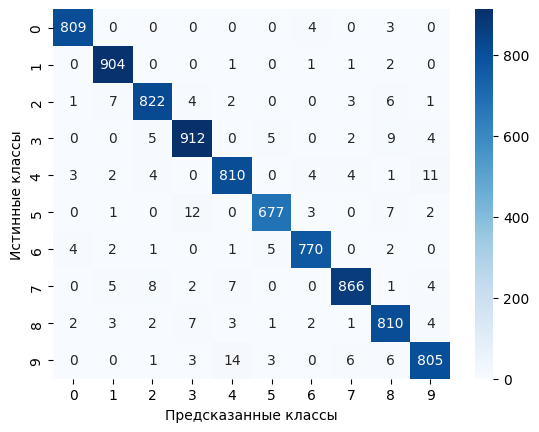

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.show()

In [ ]:
# Извлекаем HOG-признаки для тестовой выборки
X_test = test_df.values.reshape(-1, 28, 28)
X_test_hog = extract_hog_features(X_test)

# Стандартизируем тестовые данные
X_test_hog = scaler.transform(X_test_hog)

# Получаем прогнозы для тестовой выборки
test_predictions = model.predict(X_test_hog)

# Формируем DataFrame для Kaggle
submission = pd.DataFrame({'ImageId': np.arange(1, len(test_predictions) + 1), 'Label': test_predictions})
submission.to_csv('submission.csv', index=False)

# Проверка на результат выгрузки
print(submission.head())

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      0
4        5      3
